In [30]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 
import os
import math
from sympy import symbols, Eq, diff, solve
from numba import jit 


In [31]:
# Reading images
path = "Natural_Convection/"
Images = []

for filename in tqdm(os.listdir(path)):
    IMG = (cv2.imread(os.path.join(path, filename), cv2.IMREAD_GRAYSCALE)).astype('float32')
    Images.append(np.array(IMG))


100%|██████████| 61/61 [00:02<00:00, 25.86it/s]


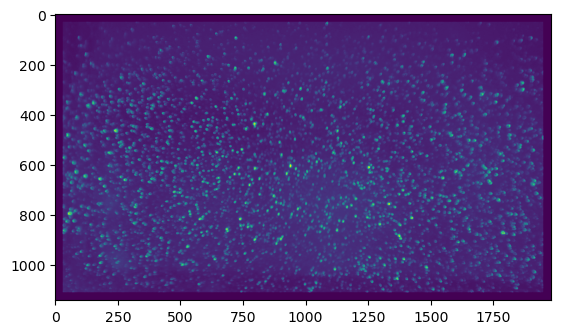

In [32]:
# Set variables
Ing = 31                        # introgation size
Src = 51                         # search window size
Ing=int(2*np.floor((Ing+1)/2)-1) # Even => Odd   
Src=int(2*np.floor((Src+1)/2)-1)
variation = int((Src - Ing)/2)
H, W = IMG.shape[:2]

# Get Two Images
Images_0 = Images[10]
Images_2 = Images[12]

# Prepaing the Images for the search window
  # by adiding zeros to berders of picture
Z_1 = np.zeros((H, Ing))
Z_2 = np.zeros((Ing, W + 2*Ing))
Images_zero = np.concatenate((Z_1,Images_0), axis=1)
Images_zero = np.concatenate((Images_zero,Z_1), axis=1)
Images_zero = np.concatenate((Z_2,Images_zero), axis=0)
Images_zero = np.concatenate((Images_zero,Z_2), axis=0)
Images_0 = Images_zero
Images_zero = np.concatenate((Z_1,Images_2), axis=1)
Images_zero = np.concatenate((Images_zero,Z_1), axis=1)
Images_zero = np.concatenate((Z_2,Images_zero), axis=0)
Images_zero = np.concatenate((Images_zero,Z_2), axis=0)
Images_2 = Images_zero
plt.imshow(Images_2)

In [33]:
# Algorithm
@jit(nopython=True)
def corr2(c1,c2): # Cross-correlation
    c1 = c1 - c1.mean()
    c2 = c2 - c2.mean()
    c12=(c1*c1).sum()*(c2*c2).sum()
    if c12>0.0:
        return (c1*c2).sum()/np.sqrt(c12)
    return -1.0
  

displacement = []      
for i in range(Ing, H+Ing, Ing):  # 991
    for j in range(Ing, W, Ing):
        count_i = i
        count_j = j
        R = np.zeros((Src-Ing+1)*(Src-Ing+1)).reshape(Src-Ing+1,Src-Ing+1)
        Introgation_window = Images_0[i:i+Ing, j:j+Ing]                                         # from the first picture we set a introgation window
        Search_window = Images_2[i-variation:i+Ing+variation, j-variation:j+Ing+variation]      # from the second window create the search matrix

        c1=np.array(Introgation_window)
        for ii in range(0, Src-Ing+1):
            for jj in range(0, Src-Ing+1):
                c2=np.array(Search_window[ii:ii+Ing,jj:jj+Ing])
                R_corr = corr2(c1,c2)  
                R[ii,jj] = R_corr

        second_position = np.argmax(R)
        Rcorr_max = np.argmax(R)/1000
        i_second, j_second = np.unravel_index(second_position, R.shape)
        x_dis = (j_second - variation)
        y_dis = (i_second - variation)
        VAm = math.atan(x_dis/(y_dis+0.01))
        VMm = math.sqrt((x_dis*x_dis)+(y_dis*y_dis))        
        dis = [i/Ing, j/Ing, x_dis, y_dis, VMm, VAm, Rcorr_max]    
        displacement.append(dis)
        ALL = np.array(displacement) 


# ok to here

num of filtered vectors 1215
num of filtered vectors 2181


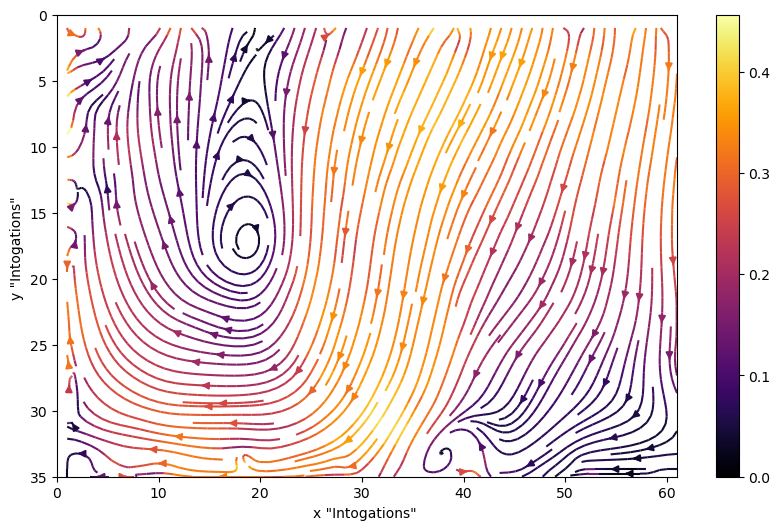

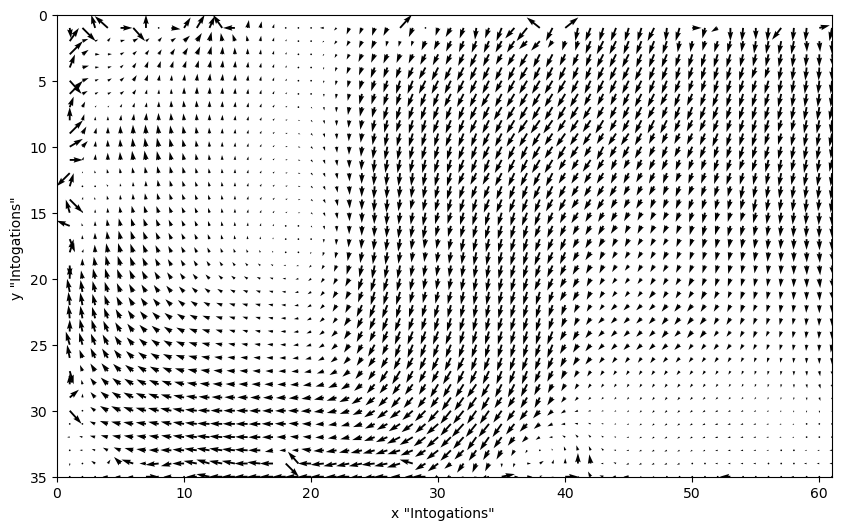

In [34]:
count_x = int(count_i/Ing)
count_y = int(count_j/Ing)
x = np.arange(1,count_x+1)
y = np.arange(1,count_y+1)
X, Y = np.meshgrid(y, x)   # Creating grids

u = ALL[:,2]
u = u.reshape(count_x,count_y)
v = ALL[:,3]
v = v.reshape(count_x,count_y)
vel_mag = np.sqrt((u*u) + (v*v))
VMm = ALL[:,4]
VMm = VMm.reshape(count_x,count_y)
VAm = ALL[:,5]
VAm = VAm.reshape(count_x,count_y)
Rcormx = ALL[:,6]
Rcormx = Rcormx.reshape(count_x,count_y)


# filter the unmathced results
counter = 0
flt_counter = 2
for c in range (0,flt_counter):
    for i in range(Ing, H-(Src+Ing), Ing):
        i = int(i/Ing)
        for j in range(Ing, W-(Src+Ing), Ing): 
            j = int(j/Ing)
            u_m = (u[i-1,j-1]+u[i-1,j]+u[i-1,j+1]+u[i,j-1]+u[i,j+1]+u[i+1,j-1]+u[i+1,j]+u[i+1,j+1])/8
            v_m = (v[i-1,j-1]+v[i-1,j]+v[i-1,j+1]+v[i,j-1]+v[i,j+1]+v[i+1,j-1]+v[i+1,j]+v[i+1,j+1])/8
            # u_m=0.25*(u[i+1,j]+u[i-1,j]+u[i,j+1]+u[i,j-1])
            # v_m=0.25*(v[i+1,j]+v[i-1,j]+v[i,j+1]+v[i,j-1])
            vel_mag_avg = (VMm[i-1,j-1]+VMm[i-1,j]+VMm[i-1,j+1]+VMm[i,j-1]+VMm[i,j+1]+VMm[i+1,j-1]+VMm[i+1,j]+VMm[i+1,j+1])/8 
            vel_ang_avg = (VAm[i-1,j-1]+VAm[i-1,j]+VAm[i-1,j+1]+VAm[i,j-1]+VAm[i,j+1]+VAm[i+1,j-1]+VAm[i+1,j]+VAm[i+1,j+1])/8 
            if (VAm[i,j] - vel_ang_avg)>10 or (u[i,j]/(u_m+0.01))>1.2 or (u[i,j]/(u_m+0.01))<0.85 or (v[i,j]/(v_m+0.01))>1.2 or (v[i,j]/(v_m+0.01))<0.85 or Rcormx[i,j]<0.3:
                counter = counter + 1
                u[i,j] = u_m
                v[i,j] = v_m
    print('num of filtered vectors', counter)
    vel_mag = np.sqrt((u*u) + (v*v))/Ing

# plot
plt.figure(figsize=(10, 6))
plt.streamplot(X, Y, u, v, density = 2, color=vel_mag, cmap=plt.cm.inferno)    # Plots are dispalcement and not velocity
plt.gca().invert_yaxis()                                                       # if you want velocity must divide it to delta T
plt.axis([0, count_y, count_x, 0])                                             # when we give two image with one frame difference the displacement is smaller
plt.xlabel('x "Intogations" ')                                                 # in comparision to two frame
plt.ylabel('y "Intogations" ')                                                 # when we use two frame must use bigger search window because the displacemnet is larger
plt.colorbar()                                                                 # for example for 31 Ing must use 61 Src for two frame difference
plt.show()                                                                     # if you want to reduce error between higher frame differences must choose bigger Src window
                                                                               # u , v is the velocities: if u = 0.2  actual u is 0.2 * Ing
v_zeg = v*(-1)
fig, ax = plt.subplots(figsize=(10, 6))
cm = plt.cm.copper
q = ax.quiver(X, Y, u, v_zeg)
plt.axis([0, count_y, count_x, 0])
plt.xlabel('x "Intogations" ')
plt.ylabel('y "Intogations" ')
plt.show()

